# Efficient Markets

This notebook describes and tests the predictability of asset returns (autocorrelations, autoregressions, out-of-sample R2, Mariano-Diebold test) and implements a simple trading strategy.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra, StatsBase

include("jlFiles/printmat.jl")
include("jlFiles/OlsGMFn.jl")

OlsGMFn

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Loading Daily S&P 500 Data

In [3]:
x  = readdlm("Data/SP500RfPs.csv",',',skipstart=1)
SP = x[:,2]                               #S&P 500 level
R  = (SP[2:end]./SP[1:end-1] .- 1) * 100  #returns, % 
T  = length(R)

dN = Date.(x[2:end,1],"d/m/y")    #convert to Date, 2:end as for R
println("Number of days in the sample: ",T)

Number of days in the sample: 9352


# Autocorrelations

The $s$th autocorrelation is 

$\rho_s = \text{Corr}(R_t,R_{t-s})$

In large samples, $\sqrt{T}\hat{\rho}_{s}\sim N(0,1)$ if the true value is $\rho_s=0$ for all $s$

In [4]:
plags = 1:5
ρ     = autocor(R,plags)

printblue("autocorrelations and t-stats:")
printTable([ρ sqrt(T)*ρ],["ρ","t-stat"],string.(plags))

autocorrelations and t-stats:
          ρ    t-stat
1    -0.026    -2.480
2    -0.044    -4.208
3    -0.007    -0.684
4    -0.022    -2.124
5    -0.018    -1.744



# Autoregressions

An AR(1) is 

$R_{t}=c+a_{1}R_{t-1}+\varepsilon_{t}$.

It can be estimated by OLS.

An asymmetric AR(1) 

$R_{t} =\alpha+\beta Q_{t-1}R_{t-1}+\gamma(1-Q_{t-1})R_{t-1}+\varepsilon
_{t}$,

where $Q_{t-1}=1 \ \text{ if } \ R_{t-1}<0$ and zero otherwise

In [5]:
x  = [ones(T-1) R[1:end-1]]
(b,_,_,Covb,) = OlsGMFn(R[2:end],x)
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb

printblue("Results from AR(1):")
printTable([b tstat],["coef","t-stat"],["constant","slope"])

Results from AR(1):
              coef    t-stat
constant     0.039     3.405
slope       -0.026    -2.481



In [6]:
Q = R[1:end-1] .< 0        #dummy: 1 if R(t-1) < 0

x = [ones(T-1) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]

(b,_,_,Covb,) = OlsGMFn(R[2:end],x)
Stdb  = sqrt.(diag(Covb))
tstat = b./Stdb

printblue("Results from AR(1) with dummies: [intercept, slope neg, slope pos]")
printTable([b tstat],["coef","t-stat"],["constant","slope (down)","slope (up)"])

Results from AR(1) with dummies: [intercept, slope neg, slope pos]
                  coef    t-stat
constant         0.001     0.058
slope (down)    -0.075    -4.395
slope (up)       0.027     1.518



## Recursive Estimation and Out-of-Sample R2

The next cell does recursive estimation (longer and longer sample) and predicts one period ahead (outside of the sample). The performance of this prediction model is measured by an "out-of-sample" $R^2$ defined as 

$R_{OS}^2 = 1- \frac{\text{MSE(forecasting model)}}{\text{MSE(benchmark forecast)}}$

In [7]:
y  = R[2:end]      #it simplifies to have separate symbol for the LHS variable
x  = [ones(T-1) Q.*R[1:end-1] (1.0.-Q).*R[1:end-1]]

(ϵ,e) = (zeros(T-1),zeros(T-1))
for t = 100:T-1
    local b
    b,        = OlsGMFn(y[1:t-1],x[1:t-1,:]) #estimate on sample 1:t-1
    ϵ[t]      = y[t] - x[t,:]'b         #forecast error, model
    e[t]      = y[t] - mean(y[1:t-1])   #forecast error, historical average
end
(ϵ,e) = (ϵ[100:end],e[100:end])

MSE_Model = mean(ϵ.^2)    #MSE for out-of-sample forecasts
MSE_Bench = mean(e.^2)

printlnPs("MSE of AR(1) model and historical mean: ",[MSE_Model MSE_Bench])
printlnPs("out-of-sample R2: ",1-MSE_Model/MSE_Bench)

MSE of AR(1) model and historical mean:      1.253     1.244
out-of-sample R2:     -0.007


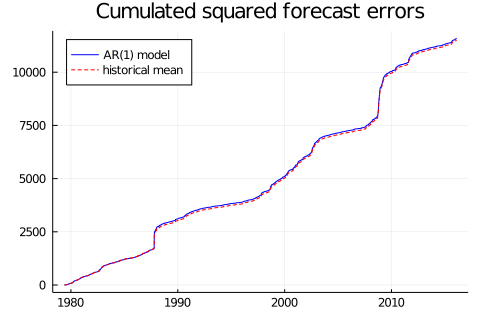

In [8]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

plot( dN[101:end],[cumsum(ϵ.^2) cumsum(e.^2)],
      linecolor = [:blue :red],
      linestyle = [:solid :dash],
      label = ["AR(1) model" "historical mean"],
      legend = :topleft,
      xticks = (xTicksLoc,xTicksLab),
      title = "Cumulated squared forecast errors" )

## Mariano-Diebold and Clark-West Tests (extra)

The Mariano-Diebold and Clark-West tests both compare the prediction errors of two models ($e$: benchmark; $\epsilon$: your model). Notice that MD test is not well suited for nested model (your model is an augmented version of the baseline model). Use the Clark-West in that case.

In [9]:
function MDCW(e,ϵ)
      g = hcat(e.^2 - ϵ.^2,       #Mariano-Diebold
               2*e.*(e - ϵ))      #Clark&West
  return g
end

MDCW (generic function with 1 method)

In [10]:
g  = MDCW(e,ϵ)          #e,ϵ are from the recursive estimation (above)
Tg = size(g,1)

μ      = mean(g,dims=1)
Stdμ   = std(g,dims=1)/sqrt(Tg)
tstats = μ./Stdμ

println("t-stats for Mariano-Diebold and Clark_West tests")
printmat(tstats)

t-stats for Mariano-Diebold and Clark_West tests
    -0.645     0.283



# A Trading Strategy

This section implements a momentum strategy (buy past winners, short sell past losers), and rebalance daily. (For simplicity, we disregard trading costs.)

## Load Data

The data set contains daily data for "dates", the equity market return, riskfree rate and the returns of the 25 Fama-French portfolios. All returns are in percent.

In [11]:
x   = readdlm("Data/MomentumSR.csv",',')
dN  = Date.(x[:,1],"yyyy-mm-dd")                  #Julia dates 
y   = convert.(Float64,x[:,2:end])

(Rm,Rf,R) = (y[:,1],y[:,2],y[:,3:end])

println("\nThe first few rows of dN, Rm and Rf")
printmat([dN[1:4] Rm[1:4] Rf[1:4]])

println("size of dN, Rm, Rf, R")
println(size(dN),"\n",size(Rm),"\n",size(Rf),"\n",size(R))

(T,n) = size(R);                      #number of periods and assets


The first few rows of dN, Rm and Rf
1979-01-02     0.615     0.035
1979-01-03     1.155     0.035
1979-01-04     0.975     0.035
1979-01-05     0.685     0.035

size of dN, Rm, Rf, R
(9837,)
(9837,)
(9837,)
(9837, 25)


## Implementing the Strategy

1.  Sort  $R_{t-1}$  across the 25 assets.
2. (In the evening of) period  $t-1$  buy 1/5 of each of the 5 best assets based on the sort in point 1. Similarly, buy -1/5 (short-sell) each of the 5 worst assets. Collect these portfolio weights in a vector $w_{t}$.
3. In period  $t$ , the return on the portfolio is $R_{p,t}=w′_{t}R_{t}$.
4. Repeat for all periods

In [12]:
Rp = fill(NaN,T)
for t = 2:T         #loop over periods, save portfolio returns
    #local s,w            #only needed in script
    s                = sortperm(R[t-1,:])  #s[1] is the index of the worst asset
    w                = zeros(n)
    w[s[1:5]]       .= -1/5
    w[s[end-4:end]] .= 1/5
    Rp[t]                = w'R[t,:]
end
Rp = Rp[2:end];                   #cut out t=1

Calculate the mean (excess) return, its standard deviation and the Sharpe ratio. Annualize by assuming 250 trading days per year. Compare with the excess return on passively holding an equity market index.

In [13]:
μ = mean(Rp)                 #strategy
σ = std(Rp)

Rme = Rm - Rf                #market
μm  = mean(Rme[2:end])
σm  = std(Rme[2:end])

printblue("Annualised results:")
result  = [μ*250;σ*sqrt(250);μ/σ*sqrt(250)]
resultm = [μm*250;σm*sqrt(250);μm/σm*sqrt(250)]
printTable([result resultm],["Strategy","market"],["mean","std","SR"])

Annualised results:
      Strategy    market
mean    16.134     8.307
std      9.871    16.770
SR       1.634     0.495



To cumulate the returns to a return index, use $(1+R_1)$, $(1+R_1)(1+R_2)$, etc. However, this does not work for excess returns, so convert them to net returns by adding the riskfree rate.

It is often more useful to show the logarithm of the return index. The slope can then be interpreted as a return.

In [14]:
Rp_b = Rp + Rf[2:end]         #add Rf to make it a net return

Ip = cumprod(1 .+ Rp_b/100)        #cumulate to return index
Im = cumprod(1 .+ Rm[2:end]/100);  #notice /100 since percentage returns

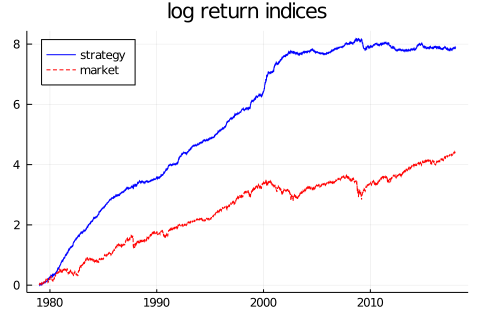

In [15]:
xTicksLoc = [Date(1980);Date(1990);Date(2000);Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

plot( dN[2:end],log.([Ip Im]),
      linecolor = [:blue :red],
      linestyle = [:solid :dash],
      label = ["strategy" "market"],
      legend = :topleft,
      xticks = (xTicksLoc,xTicksLab),
      title = "log return indices" )